In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import textwrap
import pickle
from tqdm.auto import trange, tqdm
from PIL import Image

#%%
prompt_names = [
    "blue_circle_is_above_and_to_the_right_of_blue_square",
    "blue_circle_is_above_blue_square",
    "blue_square_is_to_the_right_of_red_circle",
    "blue_triangle_is_above_red_triangle",
    "blue_triangle_is_to_the_upper_left_of_red_square",
    "circle_is_below_red_square",
    "red_circle_is_above_square",
    "red_circle_is_to_the_left_of_blue_square",
    "red_is_above_blue",
    "red_is_to_the_left_of_red",
    "triangle_is_above_and_to_the_right_of_square",
    "triangle_is_above_red_circle",
    "triangle_is_to_the_left_of_square",
    "triangle_is_to_the_left_of_triangle",
    "triangle_is_to_the_upper_left_of_square",
]


In [42]:
def split_image_into_grid(image, grid_size=5, cell_size=128, padding=2):
    """
    Split an image into a grid of subimages.
    
    Args:
        image: PIL Image to split
        grid_size: Size of grid (grid_size x grid_size)
        cell_size: Width/height of each cell in pixels
        padding: Padding between cells in pixels
        
    Returns:
        List of subimages as PIL Images
    """
    width, height = image.size
    cell_width = cell_size
    cell_height = cell_size
    
    # Verify image dimensions match expected grid
    assert (cell_width + padding) * grid_size + padding == width and \
        (cell_height + padding) * grid_size + padding == height
        
    subimages = []
    for row in range(grid_size):
        for col in range(grid_size):
            left = col * (cell_width + padding) + padding
            upper = row * (cell_height + padding) + padding
            right = left + cell_width
            lower = upper + cell_height
            subimages.append(image.crop((left, upper, right, lower)))
            
    return subimages


def load_image(step_num, prompt_id, sample_root=""):
    image_path = f"{sample_root}/step_{step_num}_sample_{prompt_names[prompt_id]}.png"
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")
    image = Image.open(image_path)
    return image


def load_image_grid(step_num, prompt_id, sample_root=""):
    image = load_image(step_num, prompt_id, sample_root)
    return split_image_into_grid(image)


In [43]:
def identity_spatial_relation(x1, y1, x2, y2):
    dx = x1 - x2  # Positive means shape1 is to the right
    dy = y1 - y2  # Positive means shape1 is lower
    # Define thresholds for "directly" above/below/left/right
    threshold = 5  # pixels
    if abs(dx) <= threshold:  # Roughly aligned vertically
        if dy < 0:
            observed_relation = 'above'
        else:
            observed_relation = 'below'
    elif abs(dy) <= threshold:  # Roughly aligned horizontally
        if dx < 0:
            observed_relation = 'left'
        else:
            observed_relation = 'right'
    else:  # Diagonal relationship
        if dx < 0 and dy < 0:
            observed_relation = 'upper_left'
        elif dx < 0 and dy > 0:
            observed_relation = 'lower_left'
        elif dx > 0 and dy < 0:
            observed_relation = 'upper_right'
        else:  # dx > 0 and dy > 0
            observed_relation = 'lower_right'
    return observed_relation

def evaluate_parametric_relation(df, scene_info, MARGIN=25):
    """
    Evaluates parametric relationships between objects in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing object detection details. It must include 
                       columns 'Shape', 'Color (RGB)', 'Center (x, y)', and 'Area'.
    scene_info (dict): Dictionary specifying the relationship details (shape, color, and spatial relationship).
    MARGIN (int): Tolerance for identifying dominant colors.

    Returns:
    dict: Dictionary with keys for overall correctness, shape match, color match, and spatial relationship match.
    """
    # Validate input
    if df.empty:
        return {"overall": False, "shape": False, "color": False, "spatial_relationship": False, "reason": "no object"}
    if not all(col in df.columns for col in ['Shape', 'Color (RGB)', 'Center (x, y)']):
        raise ValueError("DataFrame must contain 'Shape', 'Color (RGB)', and 'Center (x, y)' columns.")

    shape1 = scene_info["shape1"]
    shape2 = scene_info["shape2"]
    color1 = scene_info["color1"]
    color2 = scene_info["color2"]
    spatial_relationship = scene_info["spatial_relationship"]

    # Add color classifications to the DataFrame
    df["is_red"] = df['Color (RGB)'].apply(lambda rgb: rgb[0] > 255 - MARGIN and rgb[1] < MARGIN and rgb[2] < MARGIN)
    df["is_blue"] = df['Color (RGB)'].apply(lambda rgb: rgb[2] > 255 - MARGIN and rgb[0] < MARGIN and rgb[1] < MARGIN)

    # Check for object existence
    obj1 = df[
        ((df["Shape"] == shape1) if shape1 else True) &
        ((df["is_red"] if color1 == "red" else True) if color1 else True) &
        ((df["is_blue"] if color1 == "blue" else True) if color1 else True)
    ]
    obj2 = df[
        ((df["Shape"] == shape2) if shape2 else True) &
        ((df["is_red"] if color2 == "red" else True) if color2 else True) &
        ((df["is_blue"] if color2 == "blue" else True) if color2 else True)
    ]

    # Evaluate individual correctness
    shape_correct = (
        (shape1 is None or any(df["Shape"] == shape1)) and
        (shape2 is None or any(df["Shape"] == shape2))
    )
    color_correct = (
        (color1 is None or (color1 == "red" and any(df["is_red"])) or (color1 == "blue" and any(df["is_blue"]))) and
        (color2 is None or (color2 == "red" and any(df["is_red"])) or (color2 == "blue" and any(df["is_blue"])))
    )

    # Spatial relationship correctness
    if len(obj1) == 1 and len(obj2) == 1:
        x1, y1 = obj1["Center (x, y)"].iloc[0]
        x2, y2 = obj2["Center (x, y)"].iloc[0]
        observed_relation = identity_spatial_relation(x1, y1, x2, y2)
        spatial_correct = spatial_relationship == observed_relation
    else:
        spatial_correct = False

    # Overall correctness
    overall_correct = shape_correct and color_correct and spatial_correct

    return {
        "overall": overall_correct,
        "shape": shape_correct,
        "color": color_correct,
        "spatial_relationship": spatial_correct,
    }

In [17]:

def eval_func_factory(prompt_name):
    return lambda df: evaluate_parametric_relation(df, scene_info_collection[prompt_name])


scene_info_collection = {'blue_triangle_is_above_red_triangle':  {"color1": "blue", "shape1": "Triangle", "color2": "red", "shape2": "Triangle", "spatial_relationship": "above"},
                        'blue_circle_is_above_and_to_the_right_of_blue_square':  {"color1": "blue", "shape1": "Circle", "color2": "blue", "shape2": "Square", "spatial_relationship": "upper_right"},
                        'blue_circle_is_above_blue_square':  {"color1": "blue", "shape1": "Circle", "color2": "blue", "shape2": "Square", "spatial_relationship": "above"},
                        'blue_square_is_to_the_right_of_red_circle':  {"color1": "blue", "shape1": "Square", "color2": "red", "shape2": "Circle", "spatial_relationship": "right"},
                        'blue_triangle_is_above_red_triangle':  {"color1": "blue", "shape1": "Triangle", "color2": "red", "shape2": "Triangle", "spatial_relationship": "above"},
                        'blue_triangle_is_to_the_upper_left_of_red_square':  {"color1": "blue", "shape1": "Triangle", "color2": "red", "shape2": "Square", "spatial_relationship": "upper_left"},
                        'circle_is_below_red_square':  {"color1": None, "shape1": "Circle", "color2": "red", "shape2": "Square", "spatial_relationship": "below"},
                        'red_circle_is_above_square':  {"color1": "red", "shape1": "Circle", "color2": None, "shape2": "Square", "spatial_relationship": "above"},
                        'red_circle_is_to_the_left_of_blue_square':  {"color1": "red", "shape1": "Circle", "color2": "blue", "shape2": "Square", "spatial_relationship": "left"},
                        'red_is_above_blue':  {"color1": "red", "shape1": None, "color2": "blue", "shape2": None, "spatial_relationship": "above"},  # TODO: check 
                        'red_is_to_the_left_of_red':  {"color1": "red", "shape1": None, "color2": "red", "shape2": None, "spatial_relationship": "left"},  # TODO: check 
                        'triangle_is_above_and_to_the_right_of_square':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Square", "spatial_relationship": "upper_right"},
                        'triangle_is_above_red_circle':  {"color1": None, "shape1": "Triangle", "color2": "red", "shape2": "Circle", "spatial_relationship": "above"},
                        'triangle_is_to_the_left_of_square':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Square", "spatial_relationship": "left"},
                        'triangle_is_to_the_left_of_triangle':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Triangle", "spatial_relationship": "left"},  # TODO: check 
                        'triangle_is_to_the_upper_left_of_square':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Square", "spatial_relationship": "upper_left"},
                        }


In [ ]:
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.cv2_eval_utils import find_classify_objects, eval_func_factory, scene_info_collection, identity_spatial_relation
from circuit_toolkit.plot_utils import saveallforms

In [ ]:
exprunname = "objrel_rndembdposemb_DiT_B_pilot"
sample_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_nano_pilot/samples"

In [ ]:
# image = load_image(step_num, prompt_id)
exprunname = "objrel_rndembdposemb_DiT_B_pilot"
sample_root = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{exprunname}/samples"
eval_score = []
object_df_col = []
for prompt_id in range(len(prompt_names)):
    print(prompt_id, prompt_names[prompt_id])
    eval_func = eval_func_factory(prompt_names[prompt_id])
    
    for step_num in trange(2500, 160000, 2500):
        try:
            subimages = load_image_grid(step_num, prompt_id, sample_root=sample_root)
        except FileNotFoundError:
            print(f"No images found for step {step_num} and prompt {prompt_id}")
            break
        
        for si, subimage in enumerate(subimages):
            classified_objects_df = find_classify_objects(subimage)
            object_df_col.append(classified_objects_df)
            
            eval_result = eval_func(classified_objects_df)  # Returns a dictionary
            eval_score.append({
                "step_num": step_num,
                "sample_id": si,
                "prompt_id": prompt_id,
                "overall": eval_result["overall"],
                "shape": eval_result["shape"],
                "color": eval_result["color"],
                "spatial_relationship": eval_result["spatial_relationship"],
            })

# Convert the list of dictionaries to a DataFrame
eval_score_df = pd.DataFrame(eval_score)


0 blue_circle_is_above_and_to_the_right_of_blue_square


  0%|          | 0/63 [00:00<?, ?it/s]

1 blue_circle_is_above_blue_square


  0%|          | 0/63 [00:00<?, ?it/s]

2 blue_square_is_to_the_right_of_red_circle


  0%|          | 0/63 [00:00<?, ?it/s]

3 blue_triangle_is_above_red_triangle


  0%|          | 0/63 [00:00<?, ?it/s]

4 blue_triangle_is_to_the_upper_left_of_red_square


  0%|          | 0/63 [00:00<?, ?it/s]

5 circle_is_below_red_square


  0%|          | 0/63 [00:00<?, ?it/s]

6 red_circle_is_above_square


  0%|          | 0/63 [00:00<?, ?it/s]

7 red_circle_is_to_the_left_of_blue_square


  0%|          | 0/63 [00:00<?, ?it/s]

8 red_is_above_blue


  0%|          | 0/63 [00:00<?, ?it/s]

9 red_is_to_the_left_of_red


  0%|          | 0/63 [00:00<?, ?it/s]

10 triangle_is_above_and_to_the_right_of_square


  0%|          | 0/63 [00:00<?, ?it/s]

11 triangle_is_above_red_circle


  0%|          | 0/63 [00:00<?, ?it/s]

12 triangle_is_to_the_left_of_square


  0%|          | 0/63 [00:00<?, ?it/s]

13 triangle_is_to_the_left_of_triangle


  0%|          | 0/63 [00:00<?, ?it/s]

14 triangle_is_to_the_upper_left_of_square


  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
save_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{exprunname}/train_sample_eval"
os.makedirs(save_dir, exist_ok=True)
with open(f"{save_dir}/eval_score.pkl", "wb") as f:
    pickle.dump(eval_score_df, f)

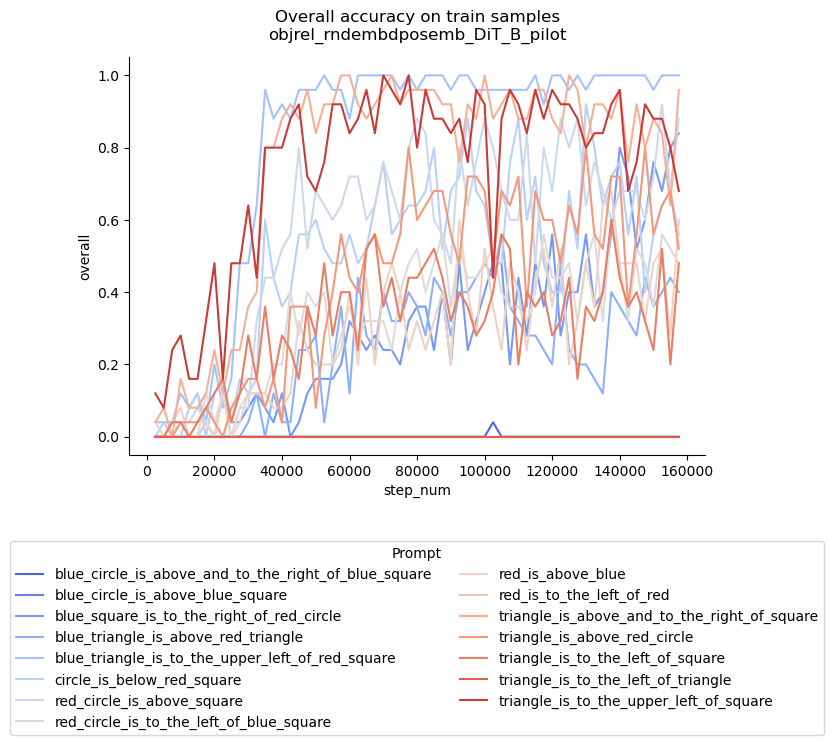

In [ ]:
# Group data and prepare the DataFrame for plotting
score_tab = eval_score_df.groupby(["step_num", "prompt_id"]).agg({"overall": "mean"}).reset_index()
score_tab["prompt_name"] = score_tab["prompt_id"].apply(lambda x: prompt_names[x])
# Create the plot
plt.figure(figsize=(8, 8))
sns.lineplot(data=score_tab, x="step_num", y="overall", hue="prompt_name", palette="coolwarm")
# Adjust the legend position to below the plot
plt.legend(title="Prompt", loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2)  # Adjust `ncol` as needed for more compact layout
plt.suptitle(f"Overall accuracy on train samples\n{exprunname}")
plt.tight_layout()
saveallforms(save_dir, "overall_train_sample_eval")
plt.show()

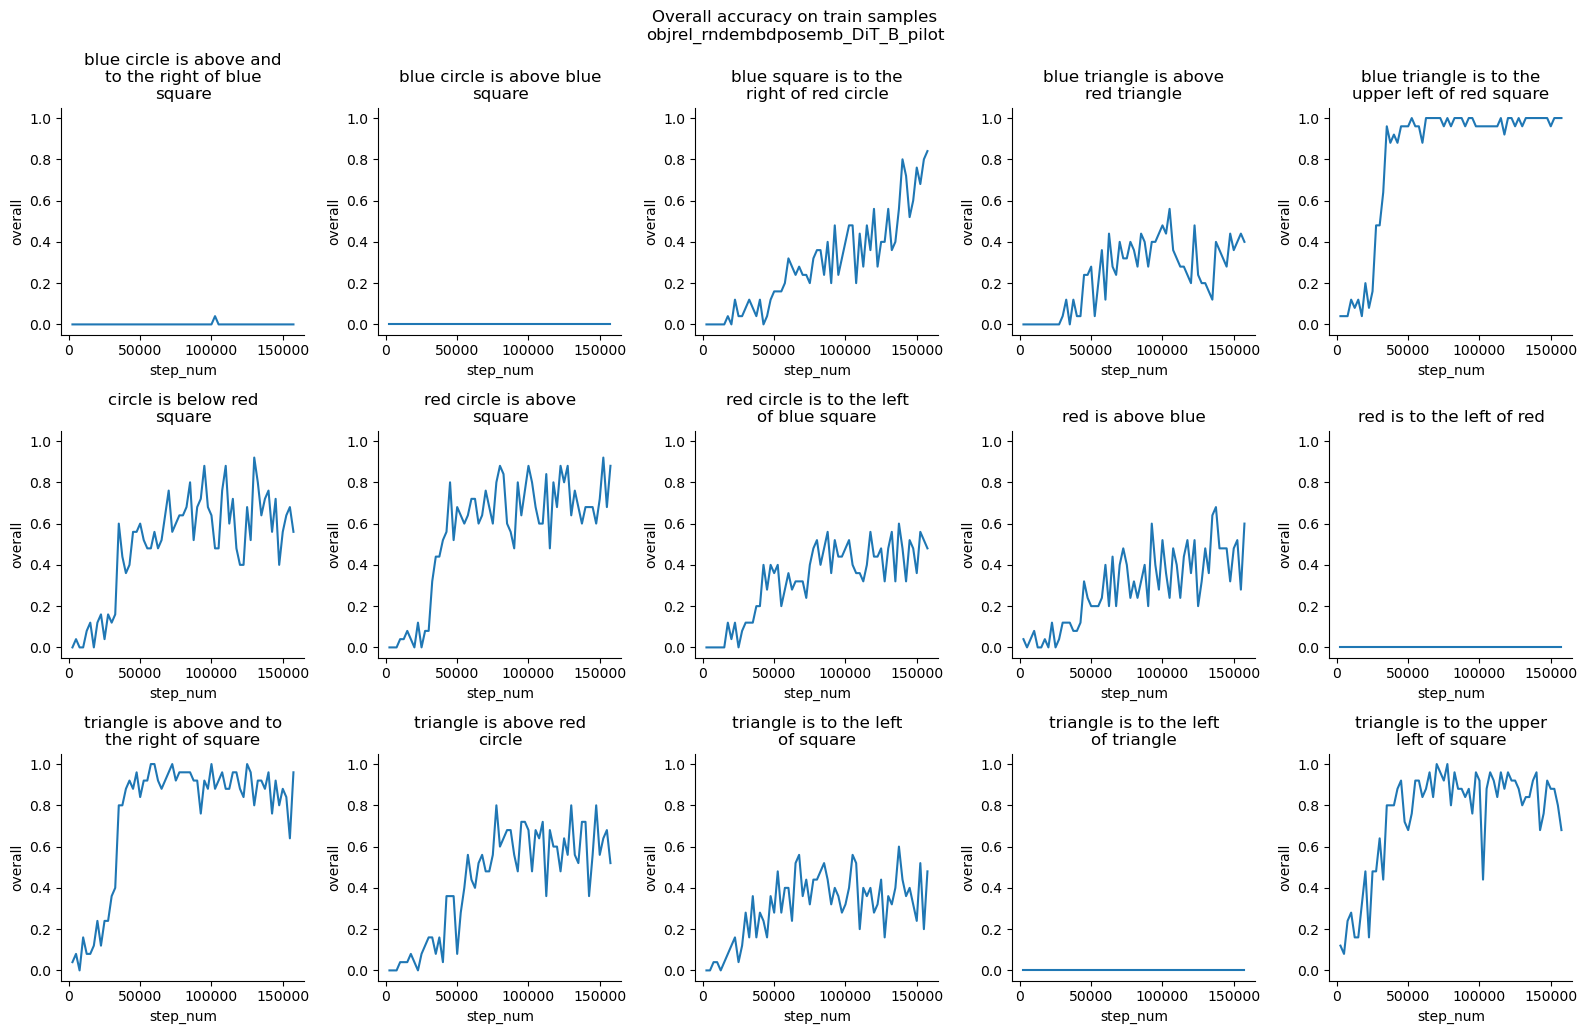

In [36]:
# label the hue with prompt names
score_tab = eval_score_df.groupby(["step_num", "prompt_id"]).agg({"overall": "mean"}).reset_index()
score_tab["prompt_name"] = score_tab["prompt_id"].apply(lambda x: prompt_names[x])
# Create a multi-panel plot
n_prompts = len(prompt_names)
n_cols = 5
n_rows = (n_prompts + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5*n_rows))
axes = axes.flatten()
# Plot each prompt in its own panel
for i, prompt in enumerate(prompt_names):
    prompt_data = score_tab[score_tab["prompt_name"] == prompt]
    sns.lineplot(data=prompt_data, x="step_num", y="overall", ax=axes[i])
    # wrap the title if too long 
    prompt = prompt.replace("_", " ")
    if len(prompt) > 10:
        prompt = "\n".join(textwrap.wrap(prompt, width=25))
    axes[i].set_title(prompt)
    axes[i].set_ylim(-0.05, 1.05)
# Remove empty subplots if any
for i in range(len(prompt_names), len(axes)):
    fig.delaxes(axes[i])
plt.suptitle(f"Overall accuracy on train samples\n{exprunname}")
plt.tight_layout()
saveallforms(save_dir, "overall_train_sample_eval_per_prompt")
plt.show()


In [ ]:
# Aggregate accuracy metrics for each component
score_tab = eval_score_df.groupby(["step_num", "prompt_id"]).agg({
    "overall": "mean",
    "shape": "mean",
    "color": "mean",
    "spatial_relationship": "mean"
}).reset_index()
score_tab["prompt_name"] = score_tab["prompt_id"].apply(lambda x: prompt_names[x])

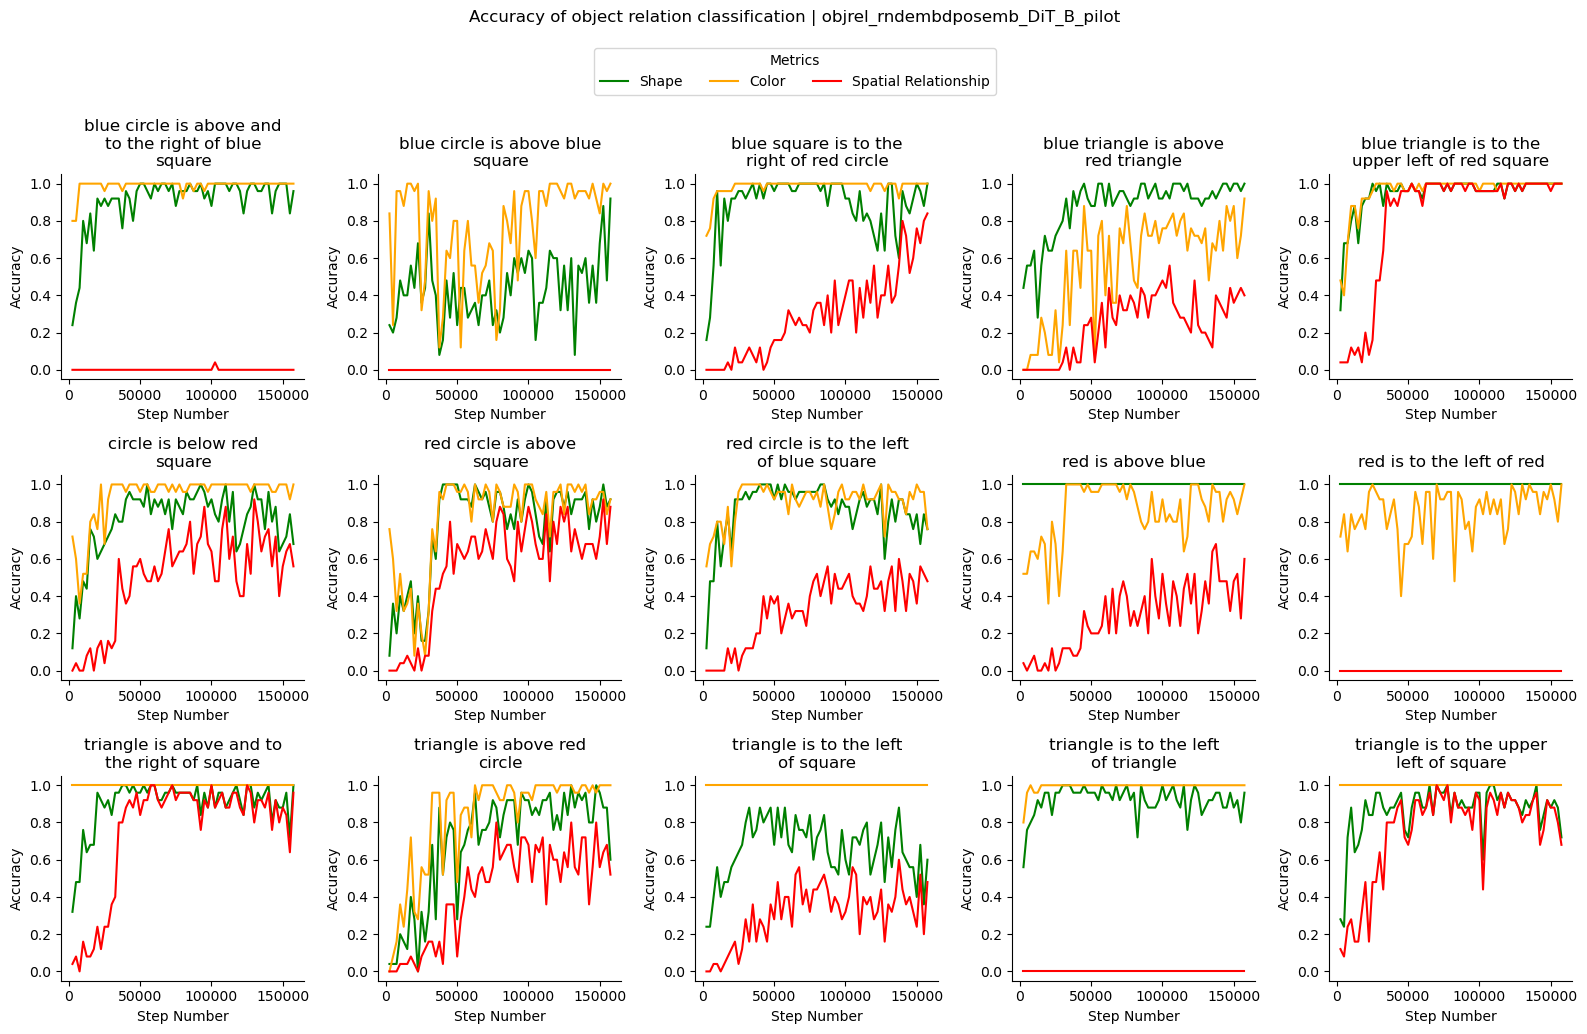

In [ ]:
# Define metrics and their colors
metrics = [ "shape", "color", "spatial_relationship"]
metric_colors = [ "green", "orange", "red"]
metric_titles = [ "Shape", "Color", "Spatial Relationship"]
n_prompts = len(prompt_names)
n_cols = 5
n_rows = (n_prompts + n_cols - 1) // n_cols  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
axes = axes.flatten()
# Plot each prompt in its own panel
for i, prompt in enumerate(prompt_names):
    ax = axes[i]
    prompt_data = score_tab[score_tab["prompt_name"] == prompt]
    
    # Plot each metric in the same subplot with different colors
    for metric, color, title in zip(metrics, metric_colors, metric_titles):
        sns.lineplot(data=prompt_data, x="step_num", y=metric, ax=ax, label=title, color=color)
    
    # Wrap the title if too long
    prompt_title = prompt.replace("_", " ")
    if len(prompt_title) > 10:
        prompt_title = "\n".join(textwrap.wrap(prompt_title, width=25))
    
    ax.set_title(prompt_title)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Step Number")
    ax.set_ylabel("Accuracy")
    
    # Remove legends from individual subplots
    ax.legend_ = None

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
# Remove empty subplots if any
for i in range(len(prompt_names), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle(f"Accuracy of object relation classification | {exprunname}")
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Leave space for the legend and title

# Add legend after tight_layout to ensure proper positioning
fig.legend(handles, labels, loc="upper center", fontsize="medium", title="Metrics", ncol=len(metrics), bbox_to_anchor=(0.5, 0.95))
saveallforms(save_dir, "overall_train_sample_eval_per_prompt_shape_color_spatial_relationship")
plt.show()